* Colab jupyter notebook끼리 import하기 위한 선언

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/밑바닥부터 시작하는 딥러닝 2

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/밑바닥부터 시작하는 딥러닝 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

In [3]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터 시작하는 딥러닝 2/sample')

In [4]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/밑바닥부터 시작하는 딥러닝 2/sample']

### word2vec

In [8]:
from sample.common.layers import MatMul

In [9]:
C = np.array([1,0,0,0,0,0,0])
W = np.random.randn(7,3)

layer = MatMul(W)
h = layer.forward(C)
print(h)

[-1.32539824 -2.08926838  1.44078416]


#### CBOW
- 모델의 맥락(2개 이상의 입력)으로부터 타깃을 추측하는 신경망

In [10]:
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (h0+h1)*0.5
s = out_layer.forward(h)

print(s)

[ 1.85998229  0.37626672 -0.33576063  1.76343693  0.03802702  0.06418951
 -0.77656805]


In [11]:
from sample.common.util import preprocess

In [12]:
text = 'You say goobye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [13]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goobye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [17]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size+1):
      if t==0:
        continue
      cs.append(corpus[idx + t])
    contexts.append(cs)
    
  return np.array(contexts), np.array(target)

In [18]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [19]:
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [20]:
from sample.common.util import preprocess, create_contexts_target, convert_one_hot

In [21]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [22]:
from sample.common.layers import MatMul, SoftmaxWithLoss

In [24]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    W_in = np.random.randn(vocab_size,hidden_size).astype('f')
    W_out = np.random.randn(hidden_size,vocab_size).astype('f')

    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []

    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
    
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:,0])
    h1 = self.in_layer1.forward(contexts[:,1])
    h = (h0+h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

In [25]:
from sample.common.trainer import Trainer
from sample.common.optimizer import Adam

In [26]:
model = SimpleCBOW(vocab_size, hidden_size=5)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 101 |  반복 1 / 2 | 시간 0[s] | 손실 1.55
| 에폭 102 |  반복 1 / 2 | 시간 0[s] | 손실 1.26
| 에폭 103 |  반복 1 / 2 | 시간 0[s] | 손실 1.62
| 에폭 104 |  반복 1 / 2 | 시간 0[s] | 손실 1.28
| 에폭 105 |  반복 1 / 2 | 시간 0[s] | 손실 1.50
| 에폭 106 |  반복 1 / 2 | 시간 0[s] | 손실 1.44
| 에폭 107 |  반복 1 / 2 | 시간 0[s] | 손실 1.46
| 에폭 108 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 109 |  반복 1 / 2 | 시간 0[s] | 손실 1.47
| 에폭 110 |  반복 1 / 2 | 시간 0[s] | 손실 1.29
| 에폭 111 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 112 |  반복 1 / 2 | 시간 0[s] | 손실 1.51
| 에폭 113 |  반복 1 / 2 | 시간 0[s] | 손실 1.49
| 에폭 114 |  반복 1 / 2 | 시간 0[s] | 손실 1.25
| 에폭 115 |  반복 1 / 2 | 시간 0[s] | 손실 1.16
| 에폭 116 |  반복 1 / 2 | 시간 0[s] | 손실 1.44
| 에폭 117 |  반복 1 / 2 | 시간 0[s] | 손실 1.48
| 에폭 118 |  반복 1 / 2 | 시간 0[s] | 손실 1.40
| 에폭 119 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 120 |  반복 1 / 2 | 시간 0[s] | 손실 1.38
| 에폭 121 |  반복 1 / 2 | 시간 0[s] | 손실 1.41
| 에폭 122 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 123 |  반복 1 / 2 | 시간 0[s] | 손실 1.26
| 에폭 124 |  반복 1 / 2 | 시간 0[s] | 손실 1.31
| 에폭 125 |  반복 1

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

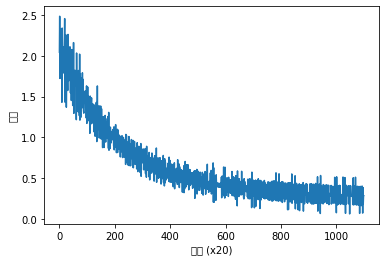

In [28]:
trainer.fit(contexts, target, max_epoch=1000, batch_size=3)
trainer.plot()

In [29]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.3992995   3.3944576  -0.3402835  -0.30953196  1.830798  ]
say [ 0.5356221  -0.87092525  1.5873233  -0.76458305 -1.1564285 ]
goobye [-0.68824905 -0.6556109  -1.081384   -0.73693514 -0.913912  ]
and [ 1.2151974  -2.983712   -1.5132611   1.416867   -0.32336885]
i [ 0.47890228  1.8383317  -0.3040045  -1.4614111  -1.240393  ]
hello [ 0.4444685   0.7711814  -2.2754147   0.99388784  0.66753757]
. [ 2.290475   2.8481104  1.2154123 -1.6543398 -0.3910223]
